In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import chardet
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    return result['encoding']

file_path = '/content/drive/MyDrive/friends.csv'

encoding = detect_encoding(file_path)
df = pd.read_csv(file_path, encoding=encoding)
df = df[df['character'].isin(['Chandler', 'Rachel'])]

df['dialogue'] = df['dialogue'].fillna('')
df['dialogue'] = df['dialogue'].astype(str)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['dialogue'] = df['dialogue'].apply(preprocess_text)
df_combined = pd.concat([df, df], ignore_index=True)
df_train, df_test = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['character'])

label_encoder = LabelEncoder()
df_train['character_encoded'] = label_encoder.fit_transform(df_train['character'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['dialogue'])
sequences_train = tokenizer.texts_to_sequences(df_train['dialogue'])
sequences_test = tokenizer.texts_to_sequences(df_test['dialogue'])
word_index = tokenizer.word_index

max_seq_length = 120
X_train = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test = pad_sequences(sequences_test, maxlen=max_seq_length)
y_train = df_train['character_encoded'].values

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=200, input_length=max_seq_length))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(150, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(150, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

model.load_weights('best_model.keras')

df_test['character_encoded'] = label_encoder.transform(df_test['character'])
y_test = df_test['character_encoded'].values

if len(X_test) != len(y_test):
    X_test = X_test[:len(y_test)]

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.5366 - loss: 0.6869 - val_accuracy: 0.6695 - val_loss: 0.6031
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.7336 - loss: 0.5294 - val_accuracy: 0.7517 - val_loss: 0.4949
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.8211 - loss: 0.3742 - val_accuracy: 0.7763 - val_loss: 0.4474
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.8542 - loss: 0.2976 - val_accuracy: 0.7908 - val_loss: 0.4467
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.8734 - loss: 0.2513 - val_accuracy: 0.7917 - val_loss: 0.4462
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.8785 - loss: 0.2391 - val_accuracy: 0.8094 - val_loss: 0.4494
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.8812 - loss: 0.2207 - val_accuracy: 0.8013 - val_loss: 0.4761
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.8920 - loss: 0.2044 - val_accu

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

df_test['character_encoded'] = label_encoder.transform(df_test['character'])
y_test = df_test['character_encoded'].values

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 88s 420ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


199/199 ━━━━━━━━━━━━━━━━━━━━ 79s 392ms/step - accuracy: 0.5271 - loss: 0.6907
Test Loss: 0.6909316182136536
Test Accuracy: 52.44%
Accuracy: 0.5244
Precision: 0.2750
Recall: 0.5244
F1 Score: 0.3608


OVERFİTTİNG GRAFİĞİ İÇİN

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


665/665 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - accuracy: 0.5230 - loss: 0.6888 - val_accuracy: 0.6513 - val_loss: 0.6218
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 136s 141ms/step - accuracy: 0.7223 - loss: 0.5437 - val_accuracy: 0.7470 - val_loss: 0.4940
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 93s 141ms/step - accuracy: 0.8136 - loss: 0.3930 - val_accuracy: 0.7692 - val_loss: 0.4610
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 138s 135ms/step - accuracy: 0.8495 - loss: 0.3202 - val_accuracy: 0.7929 - val_loss: 0.4321
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 146s 140ms/step - accuracy: 0.8670 - loss: 0.2763 - val_accuracy: 0.7882 - val_loss: 0.4543
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.8722 - loss: 0.2566 - val_accuracy: 0.8017 - val_loss: 0.4373


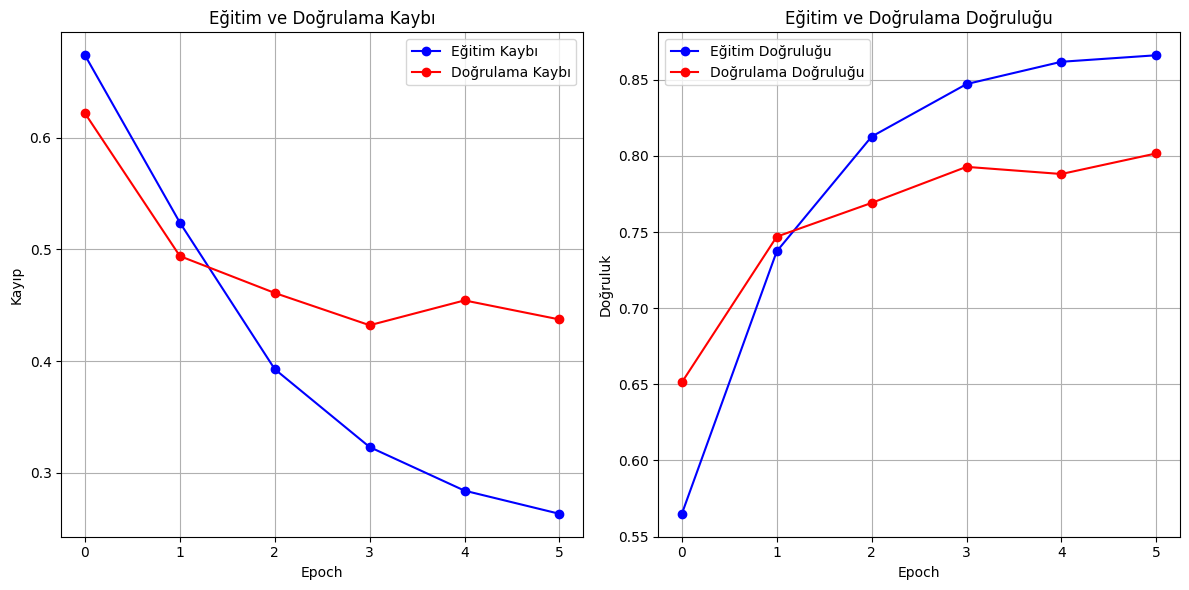

199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7712 - loss: 0.5310
Test Loss: 0.5235260725021362
Test Accuracy: 77.17%


In [ ]:
import pandas as pd
import chardet
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    return result['encoding']

file_path = 'friends.csv'

encoding = detect_encoding(file_path)
df = pd.read_csv(file_path, encoding=encoding)
df = df[df['character'].isin(['Chandler', 'Rachel'])]
df['dialogue'] = df['dialogue'].fillna('')
df['dialogue'] = df['dialogue'].astype(str)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['dialogue'] = df['dialogue'].apply(preprocess_text)
df_combined = pd.concat([df, df], ignore_index=True)

df_train, df_test = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['character'])

label_encoder = LabelEncoder()
df_train['character_encoded'] = label_encoder.fit_transform(df_train['character'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['dialogue'])
sequences_train = tokenizer.texts_to_sequences(df_train['dialogue'])
sequences_test = tokenizer.texts_to_sequences(df_test['dialogue'])
word_index = tokenizer.word_index

max_seq_length = 50
X_train = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test = pad_sequences(sequences_test, maxlen=max_seq_length)
y_train = df_train['character_encoded'].values

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_seq_length))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='red', marker='o')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red', marker='o')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

model.load_weights('best_model.keras')

df_test['character_encoded'] = label_encoder.transform(df_test['character'])
y_test = df_test['character_encoded'].values

if len(X_test) != len(y_test):
    X_test = X_test[:len(y_test)]

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
